Importing Libraries and functions

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

sys.path.append("./src")

from fft_pricer import fft_pricer
from fourier_integral import call_price_carr_madan
from error_time_module import fft_runs, plot_error_surface
from grid_module import generate_alpha_grid, generate_eta_grid, generate_n_grid

Setting up the mock data

In [ ]:
S0 = 100.0
r = 0.05
sigma = 0.2
alpha = 1.25  

strikes_analysis = np.arange(60.0, 141.0, 1.0)

maturities = [0.1, 0.5, 1.0, 2.0]

results_df = pd.DataFrame(index=strikes_analysis)
results_df.index.name = "Strike"

Defining the function to calculate the call_price using bs in the closed form

In [ ]:
def bs_call_price(S0: float, K: float, r: float, T: float, sigma: float) -> float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

Calcultating the various errors

In [ ]:
for T in maturities:
    bs_prices = np.array([bs_call_price(S0, K, r, T, sigma) for K in strikes_analysis])
    
    K_fft, P_fft = fft_pricer(S0=S0, r=r, T=T, sigma=sigma, alpha=alpha)
    
    fft_prices_interp = np.interp(strikes_analysis, K_fft, P_fft)
    
    error = np.abs(fft_prices_interp - bs_prices)
    
    results_df[f'Error_T_{T}'] = error

Plotting

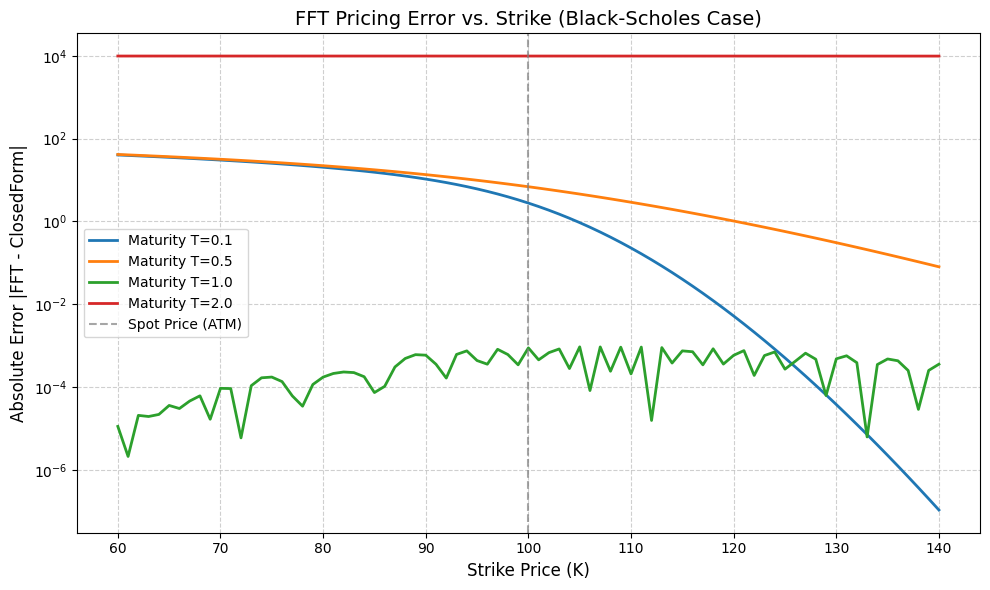


Prime righe del DataFrame degli errori:
        Error_T_0.1  Error_T_0.5  Error_T_1.0  Error_T_2.0
Strike                                                    
60.0      40.299251    41.481598     0.000011  9899.886736
61.0      39.304239    40.506412     0.000002  9899.865587
62.0      38.309226    39.531296     0.000021  9899.841370
63.0      37.314214    38.556283     0.000019  9899.813782
64.0      36.319201    37.581419     0.000022  9899.782503


In [ ]:
plt.figure(figsize=(10, 6))

for T in maturities:
    plt.plot(results_df.index, results_df[f'Error_T_{T}'], 
             label=f'Maturity T={T}', linewidth=2)

plt.title('FFT Pricing Error vs. Strike (Black-Scholes Case)', fontsize=14)
plt.xlabel('Strike Price (K)', fontsize=12)
plt.ylabel('Absolute Error |FFT - ClosedForm|', fontsize=12)

# Vertical line(ATM)
plt.axvline(x=S0, color='gray', linestyle='--', alpha=0.7, label='Spot Price (ATM)')

# log scale for y-axis
plt.yscale('log') 

plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()


print("\nPrime righe del DataFrame degli errori:")
print(results_df.head())

New setup

In [ ]:
S0, r, T, sigma = 100.0, 0.05, 1.0, 0.2
alpha, eta = 1.25, 0.25

# Range di N da testare (Potenze di 2)
# Andiamo da 2^10 (1024) a 2^20 (circa 1 milione di punti) per vedere bene il trend
powers = np.arange(10, 21) 
N_values = 2**powers

# Liste per salvare i risultati
execution_times = []

print(f"Runtime Analysis: {N_values}...")

Measurement loop

In [ ]:
for N in N_values:
    # Warm-up 
    if N == N_values[0]:
        _ = fft_pricer(S0, r, T, sigma, alpha, int(N), eta)

    # Start Timer
    start_time = time.perf_counter()
    
    _, _ = fft_pricer(S0, r, T, sigma, alpha, int(N), eta)
    
    # Stop Timer
    end_time = time.perf_counter()
    
    elapsed = end_time - start_time
    execution_times.append(elapsed)
    
    print(f"  N = {N:7d} (2^{int(np.log2(N)):2d}) -> Tempo: {elapsed:.6f} sec")



Theoretical Curve Calculation O(N log N)

In [ ]:
N_arr = np.array(N_values)
Times_arr = np.array(execution_times)

Theoretical_Complexity = N_arr * np.log2(N_arr)

# SCALING
k_factor = Times_arr[-1] / Theoretical_Complexity[-1]
Theoretical_Curve_Scaled = Theoretical_Complexity * k_factor


Plotting and report

Runtime Analysis: [   1024    2048    4096    8192   16384   32768   65536  131072  262144
  524288 1048576]...
  N =    1024 (2^10) -> Tempo: 0.000649 sec
  N =    2048 (2^11) -> Tempo: 0.000717 sec
  N =    4096 (2^12) -> Tempo: 0.001653 sec
  N =    8192 (2^13) -> Tempo: 0.002228 sec
  N =   16384 (2^14) -> Tempo: 0.004166 sec
  N =   32768 (2^15) -> Tempo: 0.010590 sec
  N =   65536 (2^16) -> Tempo: 0.022131 sec
  N =  131072 (2^17) -> Tempo: 0.046112 sec
  N =  262144 (2^18) -> Tempo: 0.094749 sec
  N =  524288 (2^19) -> Tempo: 0.234412 sec
  N = 1048576 (2^20) -> Tempo: 0.367382 sec


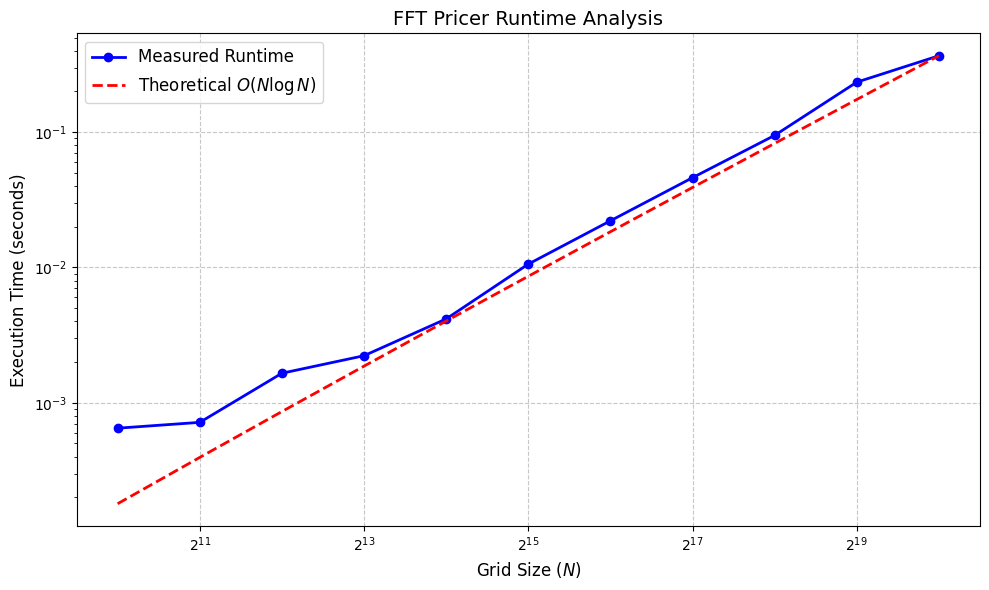

In [ ]:
plt.figure(figsize=(10, 6))

# Plot dei Dati Misurati
plt.plot(N_arr, Times_arr, 'o-', color='blue', label='Measured Runtime', linewidth=2, markersize=6)

# Plot della Curva Teorica
plt.plot(N_arr, Theoretical_Curve_Scaled, '--', color='red', label=r'Theoretical $O(N \log N)$', linewidth=2)

plt.title('FFT Pricer Runtime Analysis', fontsize=14)
plt.xlabel('Grid Size ($N$)', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Miglioramento asse X: Mostra le potenze di 2
plt.xscale('log', base=2) 
plt.yscale('log') # Log-Log plot è ottimo per verificare le leggi di potenza

plt.tight_layout()

plt.show()

Setting up the data

In [ ]:
S0 = 100.0
r = 0.01
T = 1.0
K = 100
sigma = 0.2

num_steps = 200
alpha_grid = generate_alpha_grid(alpha_lower_bound=0.5, alpha_upper_bound=2.5, num_steps=num_steps)
eta_grid = generate_eta_grid(min_eta=0.1, max_eta=0.5, num_steps=num_steps)
n_grid = generate_n_grid(min_power=1, max_power=15)

Running the FFT pricer function

In [ ]:
bs_price = bs_call_price(S0, K, r, T, sigma)
exp_df = fft_runs(alpha_grid, eta_grid, n_grid, bs_price, fft_pricer, S0, T, sigma, r, K)

Plotting

In [ ]:
plot_error_surface(exp_df, 'alpha', 'n', 'eta', 0.5, 'surface3d')

In [ ]:
plot_error_surface(exp_df, 'eta', 'n', 'alpha', 1.5, 'surface3d')